In [1]:
#Import necessary packages
from collections import namedtuple  
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import re

from pyspark import SparkContext, SparkConf
from pyspark.streaming import StreamingContext
from pyspark.sql import SQLContext, functions as F
from pyspark.sql.functions import from_unixtime, col, size, split, window


from river.metrics import R2
from river.stream import iter_pandas
from river import linear_model
from river import preprocessing

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
# create spark configuration
conf = SparkConf()
conf.setAppName("RedditStreamApp")
# create spark context with the above configuration
sc = SparkContext(conf=conf)
#sc.setLogLevel("ERROR")
# create the Streaming Context from the above spark context with interval size 10 seconds
ssc = StreamingContext(sc, 10)
# setting a checkpoint to allow RDD recovery
#ssc.checkpoint("checkpoint_RedditApp")
sqlContext = SQLContext(sc) # Initialising Spark SQL functionalities.
#Set stream to the correct socket
socket_stream = ssc.socketTextStream("127.0.0.1", 5590)


In [3]:
#This function creates a singleton isntance of the spark sqlcontext class
def get_sql_context_instance(spark_context):
    if ('sqlContextSingletonInstance' not in globals()):
        globals()['sqlContextSingletonInstance'] = SQLContext(spark_context)
    return globals()['sqlContextSingletonInstance']

(10 marks) Print the timestamps of the comments as they arrive on the Spark streaming resource

In [4]:
#This function is used to process the incoming rdd and print the timestamps of the new comments received

#Stores processed processed timestamps in case duplicate data is received
processed_timestamps = set() 

def print_comment_timestamps(rdd):
    try:

        #Extract created_utc from the RDD
        timestamps_rdd = rdd.map(lambda rec: rec.get('created_utc'))

        #Filter out already processed timestamps
        new_timestamps = timestamps_rdd.filter(lambda ts: ts not in processed_timestamps).collect()

        print('-' * 150)
        print("Question 1 - Print Comment Timestamps")

        for ts in new_timestamps:
            b = datetime.fromtimestamp(ts)
            #print("Comment Timestamp:", b)
            #output_to_display = "Comment Timestamp: " + str(b)
            processed_timestamps.add(ts)
            #Print comment timestamp
            print("Comment Timestamp: " + str(b))
            #display_output(output_to_display)

    except Exception as e:
        print("Error:", e)

(10 marks) Plot the average number of unique words (per comment) in the comments updated every 10 seconds, where the x-axis is time and the
y-axis the average number of unique words.

In [5]:
#Store data for plotting
time_list = []
avg_unique_words_list = []

#This function is used to get the average number of unique words per comment in the comments grouped in 10 sec intervals and plots them
def get_average_word_count(rdd):
    try:
        sql_context = get_sql_context_instance(rdd.context)

        #Extract relevant data and drop non-word data in comments
        row_rdd = rdd.map(lambda rec: RedditComment(
            re.sub(r'[^\w\s]', '', rec['body']),
            rec['subreddit'],
            rec['created_utc']
        ))

        comments_df = sql_context.createDataFrame(row_rdd)
        comments_df.registerTempTable("comments")

        #Get unique words in comment
        comments_with_unique_words = comments_df.withColumn(
            "unique_words",
            F.size(F.expr("filter(array_distinct(split(body, ' ')), x -> x != '')"))
        )

        #Calculate the unique words count in a 10 second window
        unique_words_count = comments_with_unique_words \
            .select(
                F.from_unixtime("created_utc").alias("comment_datetime"),
                "unique_words"
            ) \
            .groupBy(F.window("comment_datetime", "10 seconds")) \
            .agg(F.avg("unique_words").alias("avg_unique_words")) \
            .orderBy("window.start")

        unique_words_data = unique_words_count.collect()

        for row in unique_words_data:
            time_list.append(row['window']['start'])
            avg_unique_words_list.append(row['avg_unique_words'])

        #Sort counts by time
        sorted_indices = sorted(range(len(time_list)), key=lambda k: time_list[k])
        time_list_sorted = [time_list[i] for i in sorted_indices]
        avg_unique_words_sorted = [avg_unique_words_list[i] for i in sorted_indices]

        print('-' * 150)
        print("Question 2 - Average Number of Unique Words (per comment)")
        plt.figure(figsize=(10, 6))
        plt.plot(time_list_sorted, avg_unique_words_sorted, marker='o')
        plt.xlabel('Time')
        plt.ylabel('Average Unique Words Count (per 10 sec Window)')
        plt.title('Average Unique Words Count in 10 sec Comment Window over Time')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print("Error:", e)


(15 marks) Plot the cumulative number of unique words in the comments updated every 10 seconds for both subreddits, where the x-axis is time and the y-axis the total number of unique words. Your plot will contain two lines, one for the AskUK subreddit and another one for the AskAnAmerican subreddit. Do you observe any differences in the number of words between subreddits? What is your hypothesis for this observa- tion?

In [6]:
#Store unique timestamps for each subreddit in sets
askuk_time_set = set()
askanamerican_time_set = set()

#Store cumulative unique words count for each subreddit
askuk_cumulative_words_list = []
askanamerican_cumulative_words_list = []

#Store words present in each subreddit
askuk_word_set = set()
askanamerican_word_set = set()

#This function gets the cumulative number of unique words in the comments updated every 10 sec for both subreddits and plots them
def get_cumulative_word_count(rdd):
    try:
        sql_context = get_sql_context_instance(rdd.context)
        row_rdd = rdd.map(lambda rec: RedditComment(
            re.sub(r'[^\w\s]', '', rec['body']),
            rec['subreddit'],
            rec['created_utc']
        ))

        comments_df = sql_context.createDataFrame(row_rdd, ["body", "subreddit", "created_utc"])
        comments_df.registerTempTable("comments")
        comments_df = comments_df.dropDuplicates(['body', 'subreddit', 'created_utc'])
        comments_df = comments_df.withColumn(
            'comment_time',
            from_unixtime(col('created_utc')).cast('timestamp')
        )

        askuk_comments = comments_df.filter(comments_df.subreddit == "AskUK")
        askanamerican_comments = comments_df.filter(comments_df.subreddit == "AskAnAmerican")

        #Split comments into words
        askuk_cumulative = askuk_comments.withColumn(
            "unique_words",
            size(split(col("body"), " "))
        ).groupBy(window("comment_time", "10 seconds")).agg(
            F.collect_set("body").alias("words_set")
        ).orderBy("window.start")

        askanamerican_cumulative = askanamerican_comments.withColumn(
            "unique_words",
            size(split(col("body"), " "))
        ).groupBy(window("comment_time", "10 seconds")).agg(
            F.collect_set("body").alias("words_set")
        ).orderBy("window.start")

        askuk_data = askuk_cumulative.collect()
        askanamerican_data = askanamerican_cumulative.collect()

        #For each comment window add new words and timestamps to sets
        for row in askuk_data:
            timestamp = row['window']['start']
            if timestamp not in askuk_time_set:
                askuk_time_set.add(timestamp)
                words_set = set(row['words_set'])
                #Filter out words already in set and update set with new words
                new_words = words_set - askuk_word_set  
                askuk_word_set.update(new_words)
                askuk_cumulative_words_list.append(len(askuk_word_set))

        for row in askanamerican_data:
            timestamp = row['window']['start']
            if timestamp not in askanamerican_time_set:
                askanamerican_time_set.add(timestamp)
                words_set = set(row['words_set'])
                new_words = words_set - askanamerican_word_set 
                askanamerican_word_set.update(new_words)
                askanamerican_cumulative_words_list.append(len(askanamerican_word_set))

        #Sort by time
        askuk_time_list = sorted(list(askuk_time_set))
        askanamerican_time_list = sorted(list(askanamerican_time_set))

        #Calculate cumulative unique words counts at timestamp
        askuk_cumulative_sum = np.cumsum(askuk_cumulative_words_list)
        askanamerican_cumulative_sum = np.cumsum(askanamerican_cumulative_words_list)

        print('-' * 150)
        print("Question 3 - Cumulative Unique Words in Comments for each Subreddit")
        plt.figure(figsize=(10, 6))
        plt.plot(askuk_time_list, askuk_cumulative_sum, marker='o', label='AskUK')
        plt.plot(askanamerican_time_list, askanamerican_cumulative_sum, marker='o', label='AskAnAmerican')
        plt.xlabel('Timestamp')
        plt.ylabel('Cumulative Unique Words Count')
        plt.title('Cumulative Unique Words in Comments over Time per Subreddit')
        plt.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print("Error:", e)


(25 marks) Using a regression model of your choice from River you will
have to train a model to estimate the number of unique words in a com-
ment given the length of the comment. In other words, you will train
a model that will learn and predict, in real time, the number of unique
words in a comment, given the length of that comment.

In [7]:
#Create a River Linear Regression model
model = (
    preprocessing.StandardScaler() |
    linear_model.LinearRegression(intercept_lr=.1)
)

#Create the R**2 metric to track performance
metric = R2()

#Create a set to track processed data in order to not train model on duplicate data
processed_data = set()

def process_rdd_regression(rdd):
    try:
        global model, metric, processed_data

        sql_context = get_sql_context_instance(rdd.context)

        #Filter out data that has already been processed
        filtered_rdd = rdd.filter(lambda rec: (re.sub(r'[^\w\s]', '', rec['body']), rec['subreddit'], rec['created_utc']) not in processed_data)

        if filtered_rdd.isEmpty():
            print("Question 4 - Regression Model")
            print("No new data points.")

        else:
            row_rdd = filtered_rdd.map(lambda rec: (rec['body'], rec['subreddit'], rec['created_utc']))
            comments_df = sql_context.createDataFrame(row_rdd, ["body", "subreddit", "created_utc"])
            comments_df.registerTempTable("comments")
            comments_df = comments_df.dropDuplicates(['body', 'subreddit', 'created_utc'])
            comments_df = comments_df.withColumn('comment_time', from_unixtime(col('created_utc')).cast('timestamp'))
            pandas_df = comments_df.toPandas()

            #Count the number of unique words in the comment
            #pandas_df['word_count'] = pandas_df['body'].apply(lambda x: len(x.split()))
            #Obtain unique word counts
            pandas_df['word_count'] = pandas_df['body'].apply(lambda x: len(set(x.split())))
            print('-' * 150)
            print("Question 4 - Regression Model")

            #For each comment train the model
            for x, y_train in iter_pandas(pandas_df[['body']], pandas_df['word_count']):
                x = {'length': len(x['body'])}
                #Update the model with data from each comment
                model.learn_one(x, y_train)
                #Make comment length prediction using trained model
                y_pred = model.predict_one(x)
                print(f"The model predicts that comment with length {x['length']} and {y_train} unique words will have {round(y_pred)} unique words in it")
                metric.update(y_train, y_pred)

            #Update the set of processed data
            processed_data.update(filtered_rdd.map(lambda rec: (rec['body'], rec['subreddit'], rec['created_utc'])).collect())


            #Print the model slope, intercept and performance on the rdd data
            print("Model Intercept:", model['LinearRegression'].intercept)
            print("Model Slope:", model['LinearRegression'].weights)
            print("R-squared Score:", metric.get())

    except Exception as e:
        print("Error:", e)


In [8]:
#Question 1
lines = socket_stream.window(10)
fields = ("created_utc")
RedditComment = namedtuple('RedditComment', fields)
(lines.map(lambda text: eval(text))
    .foreachRDD(print_comment_timestamps)
)

#Question 2
fields = ("body", "subreddit", "created_utc")
RedditComment = namedtuple('RedditComment', fields)
(lines.map(lambda text: eval(text))
    .foreachRDD(get_average_word_count))

#Question 3
(lines.map(lambda text: eval(text))
    .foreachRDD(get_cumulative_word_count)
)

#Question 4
(lines.map(lambda text: eval(text))
    .foreachRDD(process_rdd_regression)
)

### Answers
**Code Running Instructions**
#
To run this code please make sure all the relevant packages are installed as shown in the first cell. Please have the reddit_producer.py running before running this code, you can then proceed to run all cells in the notebook. Make sure the final cell has the ssc.stop() commented out when running the code. You can uncomment and run the final cell again when you want to stop the processes. It is highly recommended to restart the notebook after running ssc.stop() to avoid conflicts. The results will show at the bottom of the notebook and are in chronological order. 
#
**Question 1:**
#
The comment timestamps obtained from the "created_utc" column are printed below to the console as they are received by the streaming system; they are in datetime format.
#
**Question 2:**
#The average number of unique words (per comment) in the comments updated every 10 seconds is plotted below for each batch of data received by the streaming system. We can see that the average varies a lot between comments.
#
**Question 3:**
#
According to the plots produced below the AskUK subreddit contains a greater number of unique words than the AskAnAmerican subreddit. This is most likely due to the fact that more comments are being received from the AskUK subreddit at the time this code is run leading to an imbalance in the word counts. This inevitably leads to there being less unique words present in the AskAnAmerican subreddit data collected. The relationship may evolve due to time zones with certain times of day being more popular for each subreddit. There may be differences in the types of conversations taking place in these subreddits resulting in more or less unique words being communicated.
#
**Question 4:**
#
The kernel output below shows the unique word count predictions being made by the River Linear Regression model for each new comment being received. It also prints for each batch of comments received the intercept and slope of the model as well as the R2 score. As more data is received the accuracy of the model tends to increase to good scores well over 0.8. A constant flow of data allows the model to adapt to changes in patterns to comments over time.



------------------------------------------------------------------------------------------------------------------------------------------------------
Question 1 - Print Comment Timestamps
Comment Timestamp: 2023-12-04 12:29:26
Comment Timestamp: 2023-12-04 12:29:29
Comment Timestamp: 2023-12-04 12:29:31
Comment Timestamp: 2023-12-04 12:29:42
Comment Timestamp: 2023-12-04 12:29:44
Comment Timestamp: 2023-12-04 12:29:45
Comment Timestamp: 2023-12-04 12:29:54
Comment Timestamp: 2023-12-04 12:30:02
Comment Timestamp: 2023-12-04 12:30:04
Comment Timestamp: 2023-12-04 12:30:06
Comment Timestamp: 2023-12-04 12:30:09
Comment Timestamp: 2023-12-04 12:30:11
Comment Timestamp: 2023-12-04 12:30:14
Comment Timestamp: 2023-12-04 12:30:23
Comment Timestamp: 2023-12-04 12:30:32
Comment Timestamp: 2023-12-04 12:30:39
Comment Timestamp: 2023-12-04 12:30:47
Comment Timestamp: 2023-12-04 12:30:58
Comment Timestamp: 2023-12-04 12:31:00
Comment Timestamp: 2023-12-04 12:31:01
Comment Timestamp: 2023-12-04 1

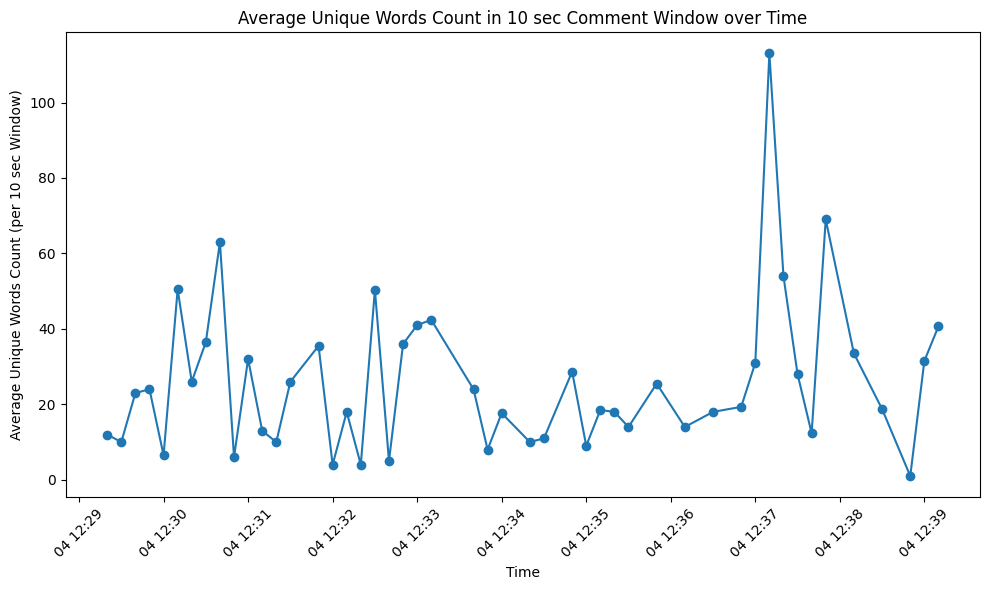

------------------------------------------------------------------------------------------------------------------------------------------------------
Question 3 - Cumulative Unique Words in Comments for each Subreddit


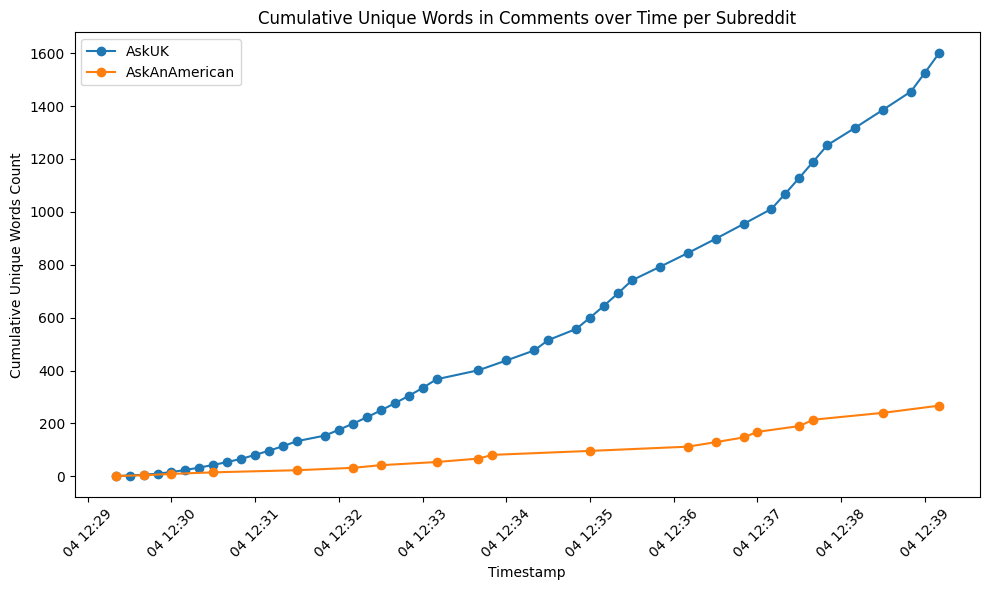

------------------------------------------------------------------------------------------------------------------------------------------------------
Question 4 - Regression Model
The model predicts that comment with length 138 and 24 unique words will have 5 unique words in it
The model predicts that comment with length 142 and 20 unique words will have 8 unique words in it
The model predicts that comment with length 55 and 10 unique words will have 8 unique words in it
The model predicts that comment with length 132 and 22 unique words will have 11 unique words in it
The model predicts that comment with length 137 and 25 unique words will have 14 unique words in it
The model predicts that comment with length 159 and 26 unique words will have 17 unique words in it
The model predicts that comment with length 141 and 16 unique words will have 16 unique words in it
The model predicts that comment with length 31 and 3 unique words will have 11 unique words in it
The model predicts that c

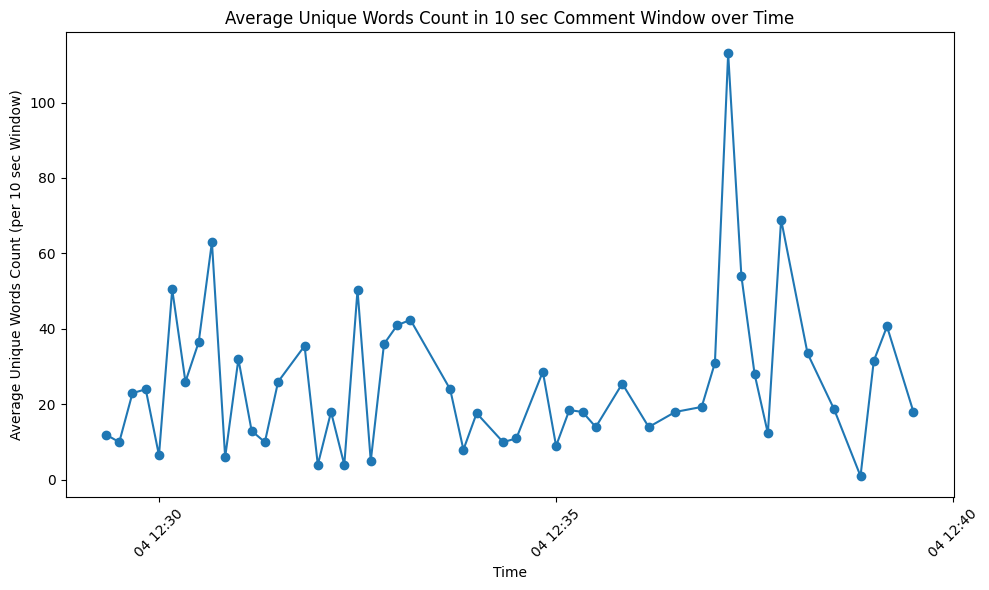

------------------------------------------------------------------------------------------------------------------------------------------------------
Question 3 - Cumulative Unique Words in Comments for each Subreddit


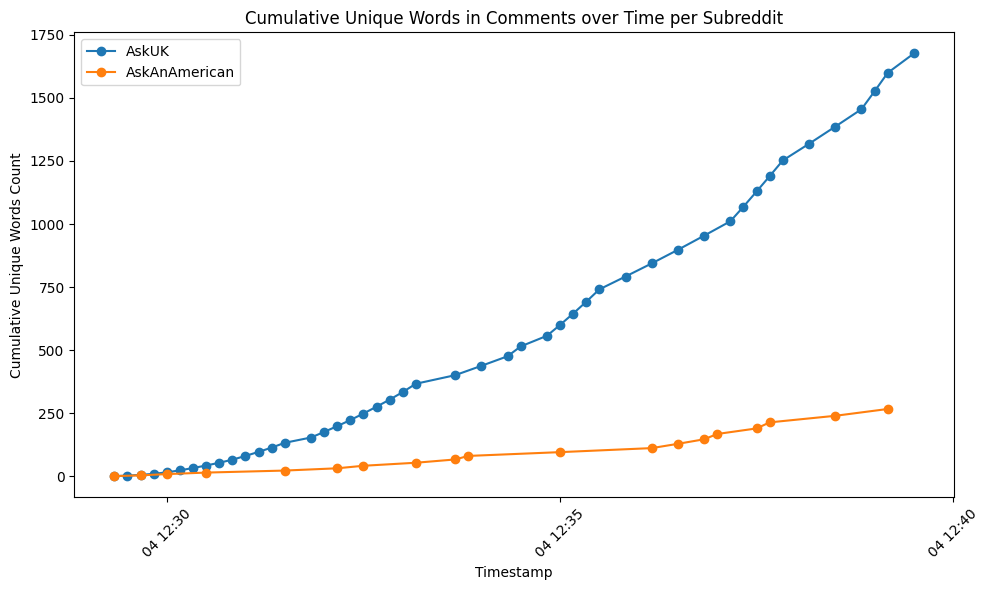

------------------------------------------------------------------------------------------------------------------------------------------------------
Question 4 - Regression Model
The model predicts that comment with length 264 and 23 unique words will have 35 unique words in it
The model predicts that comment with length 205 and 32 unique words will have 29 unique words in it
The model predicts that comment with length 69 and 14 unique words will have 14 unique words in it
The model predicts that comment with length 32 and 5 unique words will have 9 unique words in it
Model Intercept: 25.66536070571458
Model Slope: {'length': 19.99031398312314}
R-squared Score: 0.8566422093914936
------------------------------------------------------------------------------------------------------------------------------------------------------
Question 1 - Print Comment Timestamps
Comment Timestamp: 2023-12-04 12:39:39
---------------------------------------------------------------------------------

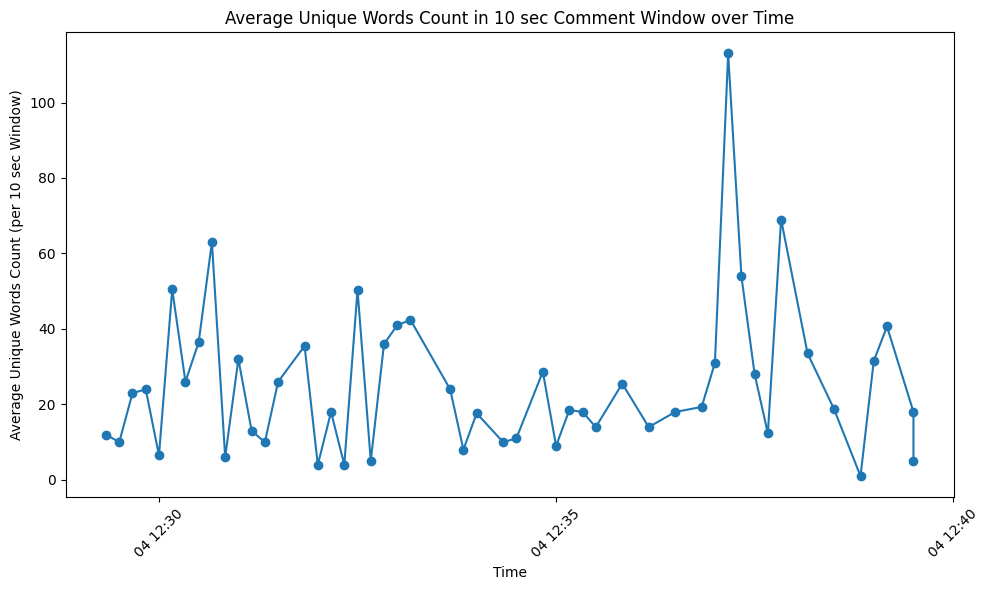

------------------------------------------------------------------------------------------------------------------------------------------------------
Question 3 - Cumulative Unique Words in Comments for each Subreddit


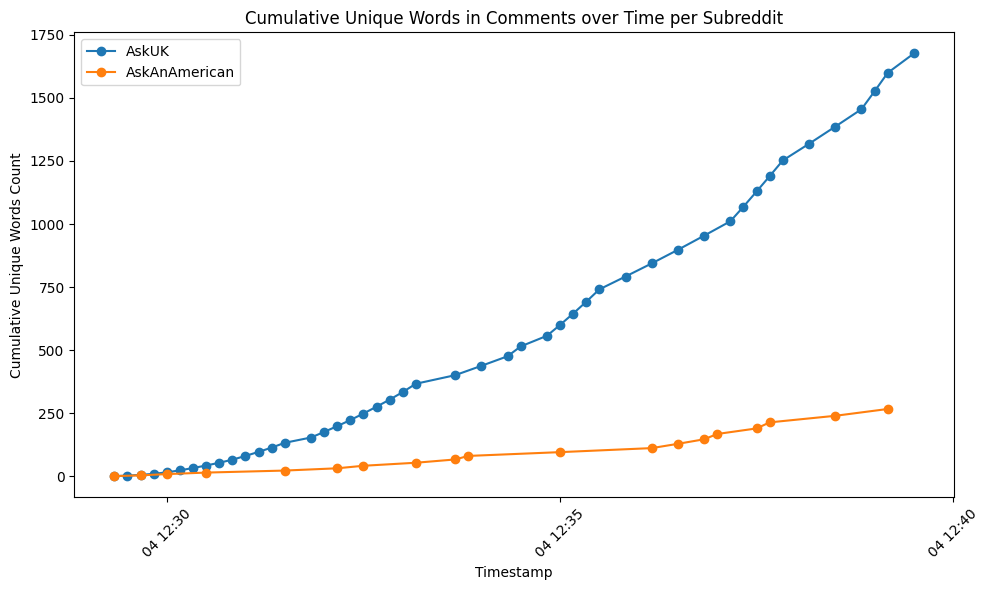

------------------------------------------------------------------------------------------------------------------------------------------------------
Question 4 - Regression Model
The model predicts that comment with length 28 and 5 unique words will have 8 unique words in it
Model Intercept: 24.899694355022827
Model Slope: {'length': 20.054802947754954}
R-squared Score: 0.8577040399566491
------------------------------------------------------------------------------------------------------------------------------------------------------
Question 1 - Print Comment Timestamps
Error: RDD is empty
Error: RDD is empty
Question 4 - Regression Model
No new data points.
------------------------------------------------------------------------------------------------------------------------------------------------------
Question 1 - Print Comment Timestamps
Comment Timestamp: 2023-12-04 12:39:50
Comment Timestamp: 2023-12-04 12:39:53
Comment Timestamp: 2023-12-04 12:39:53
Comment Timestamp: 20

In [9]:
#Start Spark Streaming Context
ssc.start()
#ssc.awaitTermination()

In [10]:
#ssc.stop()

Error: An error occurred while calling o1246.collectToPython.
: java.lang.InterruptedException
	at java.base/java.util.concurrent.locks.AbstractQueuedSynchronizer$ConditionObject.await(AbstractQueuedSynchronizer.java:1722)
	at java.base/java.util.concurrent.LinkedBlockingQueue.take(LinkedBlockingQueue.java:435)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.$anonfun$getFinalPhysicalPlan$1(AdaptiveSparkPlanExec.scala:305)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:900)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.getFinalPhysicalPlan(AdaptiveSparkPlanExec.scala:256)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.withFinalPlanUpdate(AdaptiveSparkPlanExec.scala:401)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.executeCollect(AdaptiveSparkPlanExec.scala:374)
	at org.apache.spark.sql.Dataset.$anonfun$collectToPython$1(Dataset.scala:4160)
	at org.apache.spark.sql.Dataset.$anonfun$withActi